In [1]:
# Import candidate models
from doubt import Boot, QuantileRegressor, QuantileRegressionForest
from sklearn.linear_model import (LinearRegression, PoissonRegressor, 
                                  GammaRegressor, HuberRegressor)
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor

# Import datasets
from doubt.datasets import (Airfoil, Blog, Concrete, CPU, 
                            FacebookComments, FishBioconcentration,
                            FishToxicity, ForestFire, NewTaipeiHousing,
                            PowerPlant, Protein, Servo,
                            SpaceShuttle, Yacht)

# Import external libraries
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
from scipy.stats import ks_2samp, entropy, kruskal
import matplotlib.pyplot as plt; plt.style.use('ggplot')
from sklearn.preprocessing import StandardScaler
import warnings
from collections import defaultdict

# Import internal classes
from distributions import DistributionShift
from src.psi import psi

In [2]:
from xgboost import XGBRegressor

In [3]:
dataset_classes = [Airfoil, Concrete,
                   FishToxicity, ForestFire, NewTaipeiHousing,
                   PowerPlant, Protein, Servo]

In [4]:
def monitoring_plot(dataset, base_regressor: type):
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        
        # Initialise the scaler
        standard_scaler = StandardScaler()
        
        # Load the dataset and split it
        X_train, X_test, y_train, y_test = dataset().split(test_size=0.3, random_seed=4242)
        
        # Scale the dataset
        X_train = standard_scaler.fit_transform(X_train)
        X_test = standard_scaler.transform(X_test)

        # Initialise the shifter
        shifter = DistributionShift()
        shifter.fit(X_train)

        def initialise_plot(num_rows: int, num_cols: int):
            fig, axs = plt.subplots(num_rows, num_cols, sharex=True, sharey=True, figsize=(14, 3.5 * num_rows))
            fig.suptitle(f'Monitoring plot for the {dataset.__name__} dataset under feature drift with {base_regressor.__name__}', fontsize=16)
            for j in range(num_cols):
                axs[num_rows - 1, j].set_xlabel('Number of standard deviations shifted')
            for i in range(num_rows):
                axs[i, 0].set_ylabel('Normalised values')
            return fig, axs

        # Fit the regressor
        regressor = Boot(base_regressor())
        regressor.fit(X_train, y_train, n_boots=20)

        xx = np.arange(-10, 11, 1.0)
        num_rows = X_train.shape[1] // 3
        if X_train.shape[1] % 3 > 0:
            num_rows += 1
        fig, axs = initialise_plot(num_rows=num_rows, num_cols=3)
        for idx, col in enumerate(trange(X_train.shape[1])):
            values = defaultdict(list)
            for std in xx:
                shifter.set_params(param=std, cols=[col])
                new_X_test = shifter.transform(X_test)

                predictions, intervals = regressor.predict(new_X_test, uncertainty=0.05, n_boots=20)

                values['uncertainty'].append(np.mean(intervals[:, 1] - intervals[:, 0]))
                values['psi'].append(sum(psi(X_train[:, c], new_X_test[:, c]) for c in range(X_train.shape[1])))
                values['ks'].append(sum(ks_2samp(X_train[:, c], new_X_test[:, c]).statistic for c in range(X_train.shape[1])))
                values['mse'].append(np.mean((predictions - y_test) ** 2))

            # Normalise the values
            for name, vals in values.items():
                values[name] = standard_scaler.fit_transform(np.expand_dims(vals, -1))

            for name, vals in values.items():
                if idx == 0:
                    axs[idx // 3, idx % 3].plot(xx, vals, marker='x', label=f'{name} values')
                else:
                    axs[idx // 3, idx % 3].plot(xx, vals, marker='x')

        fig.legend()
        plt.savefig('fig.png')
        plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

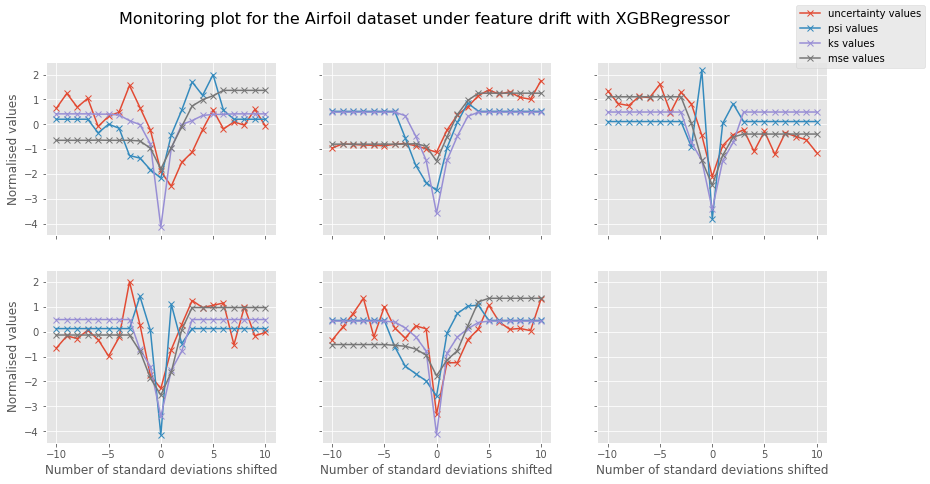

  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

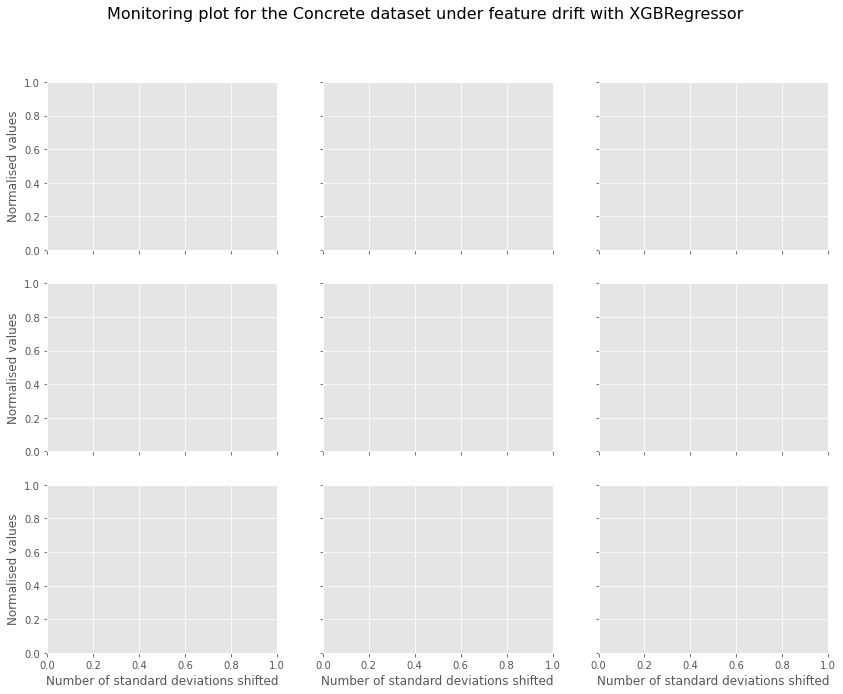

In [5]:
%%time
for dataset in dataset_classes:
    monitoring_plot(dataset, XGBRegressor)

  0%|          | 0/5 [00:00<?, ?it/s]

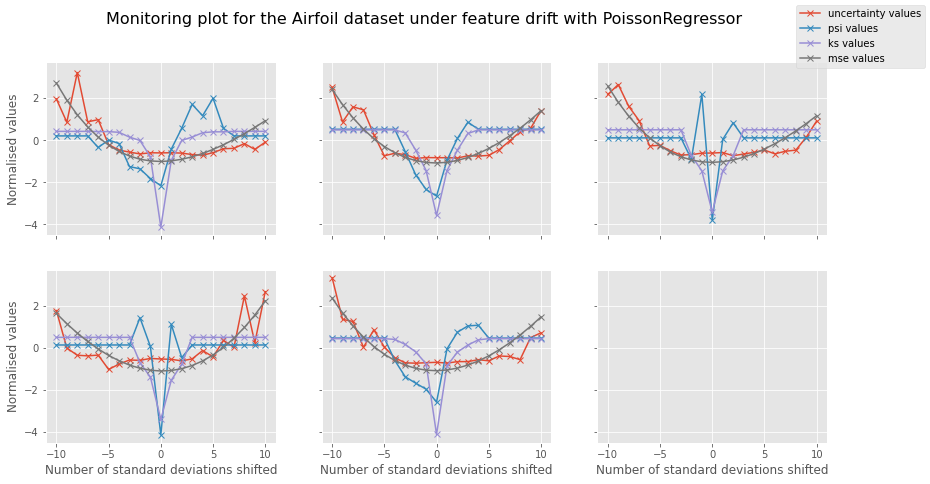

  0%|          | 0/8 [00:00<?, ?it/s]

KeyboardInterrupt: 

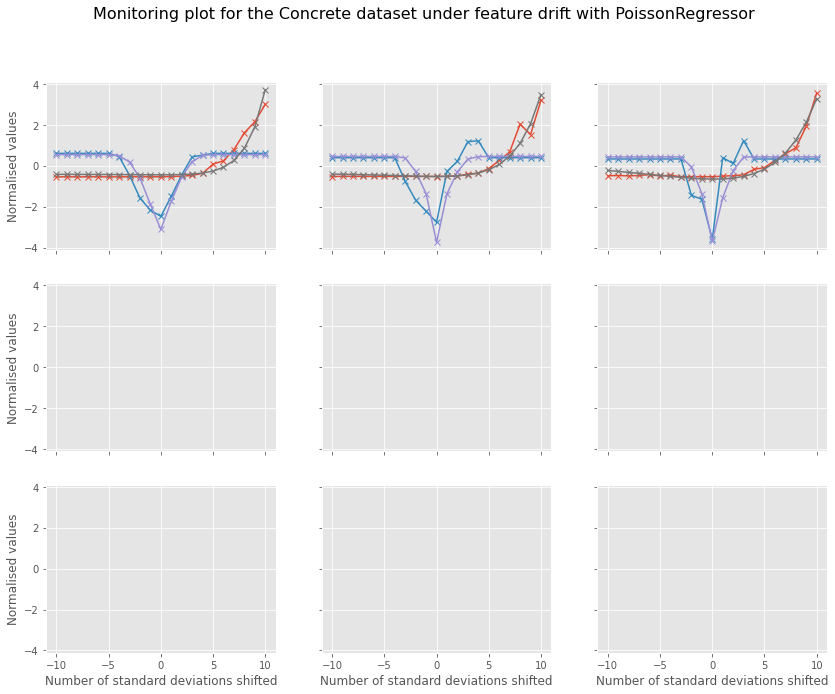

In [5]:
%%time
for dataset in dataset_classes:
    monitoring_plot(dataset, PoissonRegressor)

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

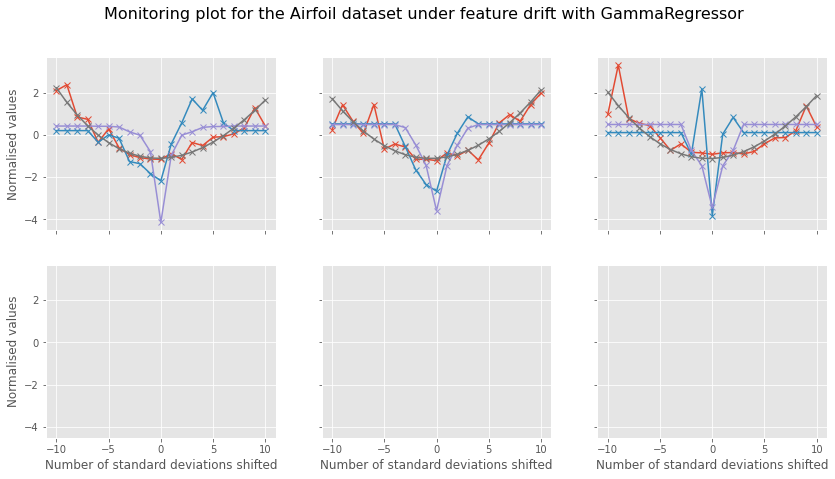

In [6]:
%%time
for dataset in dataset_classes:
    monitoring_plot(dataset, GammaRegressor)

In [ ]:
%%time
for dataset in dataset_classes:
    monitoring_plot(dataset, MLPRegressor)